In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

In [2]:
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')
#binary = fileToBinary('Data_Files/kokoro_text.txt')
binary = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

CE_symbols = qpsk(CE_binary)
#symbols_old = qpsk(Hamming74(binary))
#coded_binary = Hamming74(binary)
coded_binary = binaryTextFileToBinary('Data_Files/coded_kokoro_bin.txt')

In [239]:
'''print(type(coded_binary))
text_file = open("Data_Files/coded_kokoro_bin.txt", "w")
text_file.write(coded_binary)
text_file.close()
'''
# Set the parameters for transmission
CP = 704 
N = 4096
guard = 5
CE_repeat = 20

frame_data_length = 90

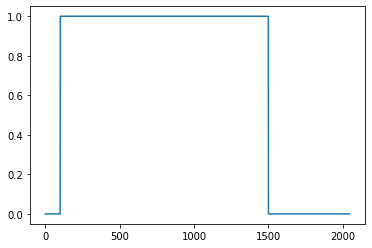

In [240]:
# Make your instructions
instruction = []
for i in range(2047):
    if i <1500 and i > 100:
        instruction.append(1)
    else: 
        instruction.append(0)
plot_y(instruction)

In [241]:
symbols = varyingModulation_std(coded_binary,instruction, N, CE_binary, 50000)
#symbols_verify = qpsk(coded_binary)

bitcount 2798
additional  1190
data length  5580820
new data len  5582010
symbol number 100 is done.
symbol number 200 is done.
symbol number 300 is done.
symbol number 400 is done.
symbol number 500 is done.
symbol number 600 is done.
symbol number 700 is done.
symbol number 800 is done.
symbol number 900 is done.
symbol number 1000 is done.
symbol number 1100 is done.
symbol number 1200 is done.
symbol number 1300 is done.
symbol number 1400 is done.
symbol number 1500 is done.
symbol number 1600 is done.
symbol number 1700 is done.
symbol number 1800 is done.
symbol number 1900 is done.


In [242]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,1, volume = 100)

In [243]:
# For channel esimation (CE)

# prepare channel esitimation data to be transmitted 
CE_Time, CE_Freq = ofdmSymbols(CE_symbols, CP, N)
print(CE_Time.shape)

print(symbols.shape)
Payload_Time, Payload_Freq = ofdmSymbols(symbols, CP, N)

extra = frame_data_length - len(Payload_Time)%frame_data_length
print(len(Payload_Time), extra)
for i in range(extra):
    Payload_Time = np.concatenate((Payload_Time, [CE_Time[1]]))
    
print(Payload_Time.shape)
num_of_frames = int(len(Payload_Time)/frame_data_length)

print(num_of_frames)

num_of_frames = 1
offset = 0
Payload_Time = Payload_Time[offset*frame_data_length:(num_of_frames + offset)*frame_data_length]

print(Payload_Time.shape)

encoded symbols length =  6000
(3, 4800)
(4083765,)
encoded symbols length =  4083765
1995 75
(2070, 4800)
23
(90, 4800)


In [244]:
# Prepare what to transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_Time[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_Time, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

In [245]:
x = save_transmit( tuple(Payload) , playOutput=True)
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

playing
[0, 1]
[32767 32696 32486 ... -8714  5897   935]
Transmit signal is  14.0  seconds


[0.0, -5.365, -4.321, -3.644, -6.759, -6.552, -6.532, -6.471, -6.295, -6.309, -6.316, -6.351, -6.372, -6.339, -6.299]
[-22.159, -21.957, -21.989, -21.975, -21.879, -21.998, -21.964, -21.92, -21.923, -21.984, -21.868, -22.031, -21.894, -22.177, -28.206]
param  [-3.0250645e-03 -6.3077888e+00]


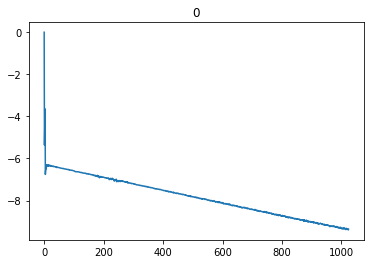

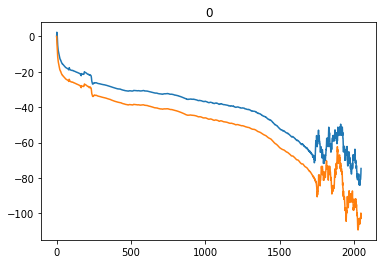

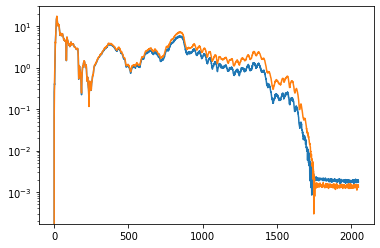

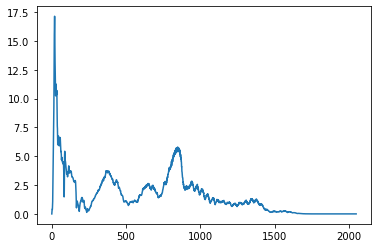

In [280]:
y = audioDataFromFile('Wav_Files/recording.wav')


data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)

freq_data = []
# big loop to find out everything
for i in range(num_of_frames):
    # obtain only the time series we are interested in 
    y_data = removeChirpAndPause_std(y, chirp_signal, 400000, plot = False, rng = 100)
    
    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Examine any phase shift 
    impulse_front, TF_front = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    start_index = 0
    end_index = start_index + 2048
    TF_front_relevant =TF_front[start_index:end_index]
    TF_end_relevant = TF_end[start_index:end_index]
    
    
    angle_front = np.unwrap(np.angle(TF_front_relevant))
    angle_end = np.unwrap(np.angle(TF_end_relevant))

    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_front[p], 3))
    

    print(difference[:15])
    print(difference[-15:])

    
    plot_y(difference[:1024], f = i+100, title = i)
    plot_y(angle_front, f = i+80, title = i)
    plot_y(angle_end, f= i+80)
    
    plt.figure(1000+i)
    plt.yscale("log")
    plt.plot(abs(np.array(TF_front))[:2048])
    plt.plot(abs(np.array(TF_end))[:2048])
    plot_y(abs(np.array(TF_front))[:2048], f=i+2)


    stable_phase_start = 400
    stable_phase_length = 400
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    param = np.polyfit(p,q,1)
    print("param ", param)
    grad = param[0]
    
    if i == 0:
        freq_data = sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)
    else:
        freq_data = np.concatenate((freq_data, \
                        sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)))
    
    y = remaining_end
    

    

(-1, 1)

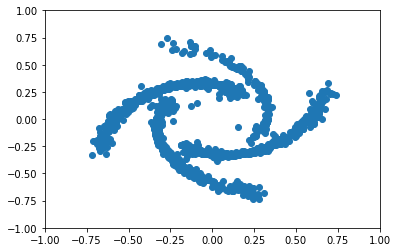

In [279]:
plot_res = np.array(freq_data[40])[100:1500]
plt.scatter(plot_res.real, plot_res.imag)
window = 1
plt.xlim(-1*window,window)
plt.ylim(-1*window, window)

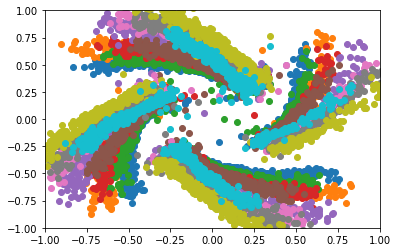

In [249]:
start = 70
duration = 10
for i in range(duration):
    plot_res = np.array(freq_data[start+i])[100:1500]
    plt.scatter(plot_res.real, plot_res.imag)
    window = 1
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)

In [250]:
def demodVaryingModulation_std(constellation_array, instruct_list, N):
    inst_len = int(N/2 -1)
    assert inst_len == len(instruct_list), "instruction list length must match DFT length"
  
    binary_block = []
    
     # j = variable to iterate through the constellation symbols
    i = 0 #variable to iterate through the instructions symbols
    
    for j in range(len(constellation_array)):
            
        if instruct_list[i] == 1:
            binary_block.append(iqpsk(constellation_array[j:j+1]))
        
        elif instruct_list[i] == 2: 
            binary_block.append(iqam16(constellation_array[j:j+1]))
        
        elif instruct_list[i] == 3: 
            binary_block.append(ibpsk(constellation_array[j:j+1]))
        else:
            pass
        
        i += 1
        
        if i > inst_len-1:
            i = 0
    
    return "".join(binary_block) 


In [275]:
print(len(freq_data))
data1 = np.concatenate(tuple(freq_data[:89]))#[4*20:4*40]
predict = iHamming74(demodVaryingModulation_std(data1, instruction, N))
#predict = iHamming74(iqpsk(data1))

print(len(predict))
print(len(binary))

90
142296
3189040


In [ ]:
str_to_bytearray(predict).decode('utf-8', 'replace')

In [ ]:
instruction = []
for i in range(2047):
    if i <200:
        instruction.append(1)
    else: 
        instruction.append(2)
    
print(len(instruction), type(instruction))

In [ ]:
test_bin = CE_binary
len(test_bin)
len(coded_binary)/len(test_bin)

In [ ]:
blah = varyingModulation_test(test_bin,instruction, N, CE_binary)
print(blah)
print(len(blah), len(CE_symbols))